<a href="https://colab.research.google.com/github/bs3537/DS-Unit-2-Applied-Modeling/blob/master/V2_MAE_14_385_hyperparameter_tuning_XGBoostRegressor__onehotencoder_Bhav_DengueAI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
#https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/

In [0]:
#Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. 

In [0]:
#Performance metric = mean absolute error

##LIST OF FEATURES:
You are provided the following set of information on a (year, weekofyear) timescale:

(Where appropriate, units are provided as a _unit suffix on the feature name.)

###City and date indicators
1. city – City abbreviations: sj for San Juan and iq for Iquitos
2. week_start_date – Date given in yyyy-mm-dd format
###NOAA's GHCN daily climate data weather station measurements
1. station_max_temp_c – Maximum temperature
2. station_min_temp_c – Minimum temperature
3. station_avg_temp_c – Average temperature
4. station_precip_mm – Total precipitation
5. station_diur_temp_rng_c – Diurnal temperature range

###PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

6. precipitation_amt_mm – Total precipitation

###NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

7. reanalysis_sat_precip_amt_mm – Total precipitation
8. reanalysis_dew_point_temp_k – Mean dew point temperature
9. reanalysis_air_temp_k – Mean air temperature
10. reanalysis_relative_humidity_percent – Mean relative humidity
11. reanalysis_specific_humidity_g_per_kg – Mean specific humidity
12. reanalysis_precip_amt_kg_per_m2 – Total precipitation
13. reanalysis_max_air_temp_k – Maximum air temperature
14. reanalysis_min_air_temp_k – Minimum air temperature
15. reanalysis_avg_temp_k – Average air temperature
16. reanalysis_tdtr_k – Diurnal temperature range

###Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
17. ndvi_se – Pixel southeast of city centroid
18. ndvi_sw – Pixel southwest of city centroid
19. ndvi_ne – Pixel northeast of city centroid
20. ndvi_nw – Pixel northwest of city centroid

####TARGET VARIABLE = total_cases label for each (city, year, weekofyear)

In [0]:
import sys

In [0]:
#Load train features and labels datasets
train_features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_train.csv')

In [7]:
train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [8]:
train_features.shape

(1456, 24)

In [0]:
train_labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_labels_train.csv')

In [10]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [11]:
train_labels.shape

(1456, 4)

In [0]:
#Merge train features and labels datasets

In [0]:
train = pd.merge(train_features, train_labels)

In [14]:
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [15]:
train.shape
#city, year and week of year columns are duplicate in train_features and train_labels datasets so the total_cases column is added to the features dataset

(1456, 25)

In [16]:
train.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [17]:
#Do train, val split
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              random_state=42)
train.shape, val.shape

((1164, 25), (292, 25))

In [0]:
#Load test features dataset
test = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_test.csv')

In [19]:
test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [20]:
test.shape

(416, 24)

In [0]:
#Pandas Profiling
#!pip install pandas-profiling==2.*

In [0]:
#import pandas_profiling

In [0]:
#profile_report = train.profile_report(
    #check_correlation_pearson=False,
    #correlations={
        #'pearson': True,
        #'spearman': False,
        #'kendall': False,
        #'phi_k': False,
        #'cramers': False,
        #'recoded': False,
    #},
    #plot={'histogram': {'bayesian_blocks_bins': False}},
#)

#profile_report

#Exploring pairwise relationships 


In [0]:
#import seaborn as sns
#sns.pairplot(train)

###Baseline statistics for the target variable total_cases in train dataset

In [25]:
train['total_cases']. describe()

count    1164.000000
mean       23.116838
std        39.493135
min         0.000000
25%         4.000000
50%        12.000000
75%        27.000000
max       461.000000
Name: total_cases, dtype: float64

####Baseline mean and mean absolute error

In [26]:
guess = train['total_cases'].mean()
print('At the baseline, the mean total number of dengue cases is=', guess)

At the baseline, the mean total number of dengue cases is= 23.116838487972508


In [0]:
#If we had just guessed that the total number of dengue cases was 23.11 for a city in a particular year, we would be off by how much?

In [28]:
from sklearn.metrics import mean_absolute_error

# Arrange y target vectors
target = 'total_cases'
y_train = train[target]
y_val = val[target]

# Get mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

# Train Error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train mean absolute error: {mae:.2f} dengue cases per year')

# Test Error
y_pred = [guess] * len(y_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Validation mean absolute error: {mae:.2f} dengue cases per year')

Mean Baseline (using 0 features)
Train mean absolute error: 20.99 dengue cases per year
Validation mean absolute error: 27.79 dengue cases per year


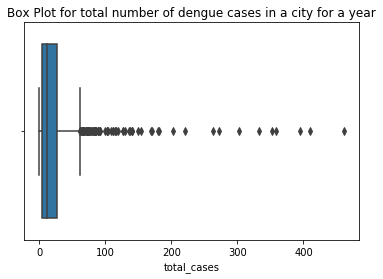

In [29]:
#Box Plot for total number of dengue cases in a city for a year
import seaborn as sns
sns.boxplot(train.total_cases)
plt.title('Box Plot for total number of dengue cases in a city for a year')
plt.show()

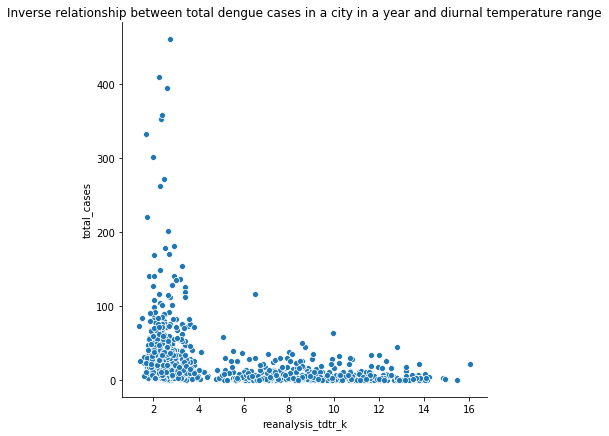

In [30]:

sns.pairplot(train, x_vars='reanalysis_tdtr_k', y_vars='total_cases', kind='scatter', height=6)
plt.title('Inverse relationship between total dengue cases in a city in a year and diurnal temperature range')
plt.show()

#####From the above plot, there seems to be an inverse relationship between total dengue cases in a city in a year and Diurnal temperature range by NOAA's NCEP Climate Forecast System Reanalysis measurements 

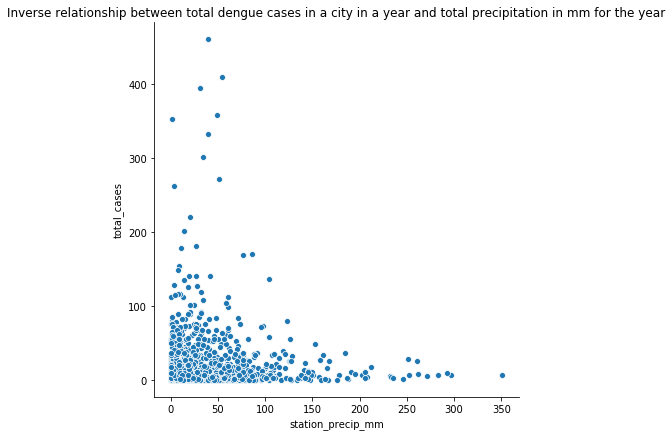

In [31]:
sns.pairplot(train, x_vars='station_precip_mm', y_vars='total_cases', kind='scatter', height=6)
plt.title('Inverse relationship between total dengue cases in a city in a year and total precipitation in mm for the year')
plt.show()

###Using Ridge Regression 

In [32]:
#numeric features in train dataset
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
year,1164.0,2001.026632,5.459314,1990.000000,1997.000000,2002.000000,2006.000000,2010.000000
weekofyear,1164.0,26.399485,15.194617,1.000000,13.000000,26.000000,40.000000,53.000000
ndvi_ne,1008.0,0.143563,0.138596,-0.406250,0.045912,0.130200,0.249071,0.508357
ndvi_nw,1127.0,0.129350,0.118388,-0.309600,0.047733,0.120500,0.214664,0.454429
ndvi_se,1149.0,0.202600,0.073291,0.006183,0.152729,0.195657,0.248500,0.538314
ndvi_sw,1149.0,0.200406,0.084038,-0.063457,0.140714,0.186900,0.246729,0.546017
precipitation_amt_mm,1152.0,46.153264,43.691925,0.000000,9.535000,38.680000,70.615000,389.600000
reanalysis_air_temp_k,1155.0,298.676894,1.371270,294.635714,297.641429,298.600000,299.804286,302.200000
reanalysis_avg_temp_k,1155.0,299.196469,1.279814,294.892857,298.232143,299.228571,300.200000,302.928571
reanalysis_dew_point_temp_k,1155.0,295.211953,1.547203,289.642857,294.060000,295.555714,296.454286,298.450000


In [33]:
#non-numeric features in train dataset
train.select_dtypes(exclude='number').describe().T

,count,unique,top,freq
city,1164,2,sj,750
week_start_date,1164,903,2006-12-24,2


In [0]:
#we need to convert week_start_date to numeric form uisng pd.to_dateime function
#wrangle function 

def wrangle(X):
  X = X.copy()
       
    # Convert week_start_date to numeric form
  X['week_start_date'] = pd.to_datetime(X['week_start_date'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['week_start_date'].dt.year
  X['month_recorded'] = X['week_start_date'].dt.month
  X['day_recorded'] = X['week_start_date'].dt.day
  X = X.drop(columns='week_start_date')
  X = X.drop(columns='year')
    #any feature engineering, write here below
    
    # return the wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


In [0]:
# The status_group column is the target
target = 'total_cases'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [37]:
pip install category_encoders

In [0]:

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import model_selection, preprocessing

In [0]:
#One hotencoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.fit_transform(X_val)
X_test_encoded = encoder.fit_transform(X_test)

In [40]:
model = XGBRegressor(n_estimators=150,    
                      max_depth=15,          
                      learning_rate=0.1,    
                      random_state=42,
                      n_jobs=-1)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

# Fit on train, score on val
model.fit(X_train_encoded, y_train,
          eval_metric='mae',
          eval_set=eval_set, 
          early_stopping_rounds=25)

[06:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:20.7057	validation_1-mae:28.39
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 25 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[1]	validation_0-mae:18.9298	validation_1-mae:26.6406
[2]	validation_0-mae:17.3148	validation_1-mae:25.0929
[3]	validation_0-mae:15.8551	validation_1-mae:23.6249
[4]	validation_0-mae:14.5255	validation_1-mae:22.3332
[5]	validation_0-mae:13.3107	validation_1-mae:21.2058
[6]	validation_0-mae:12.2093	validation_1-mae:20.0981
[7]	validation_0-mae:11.1982	validation_1-mae:19.2679
[8]	validation_0-mae:10.2709	validation_1-mae:18.5413
[9]	validation_0-mae:9.42204	validation_1-mae:17.9452
[10]	validation_0-mae:8.65367	validation_1-mae:17.376
[11]	validation_0-mae:7.94702	validation_1-mae:16.9169
[12]	validation_0-mae:7.31702	validation_1-mae:16.4256
[13]	validation_0-mae:6.73232	validation_1-mae:16.0104
[14]	validation_0-mae:6.20166	validation_1-mae:15.67
[15]	validation_0-mae:5.71178	validation_1-mae:15.3975
[16]	validation_0-mae:5.26097	validation_1-mae:15.2057
[17]	validation_0-mae:4.85025	validation_1-mae:15.0523
[18]	validation_0-mae:4.47301	validation_1-mae:14.8976
[19]	validation_0-mae:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

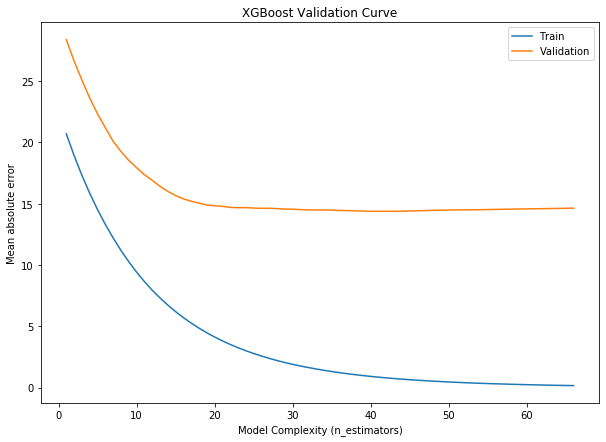

In [41]:
results = model.evals_result()
train_error = results['validation_0']['mae']
val_error = results['validation_1']['mae']

iterations = range(1, len(train_error) + 1)

plt.figure(figsize=(10,7))
plt.plot(iterations, train_error, label='Train')
plt.plot(iterations, val_error, label='Validation')
plt.title('XGBoost Validation Curve')
plt.ylabel('Mean absolute error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();